# Описание проекта

Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

В качестве тренировочных данных представляется датасет train.csv с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

## Шаг 1. Загрузите данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
#pip install -U seaborn

In [3]:
data = pd.read_csv('/1/train.csv')

In [4]:
data_sample = pd.read_csv('/1/sample_submission.csv')

## Шаг 2. Проведите исследовательский анализ данных (EDA)

### Посмотрим на датасет с данными заказов

In [5]:
def basic_info(data):
    data.columns = data.columns.str.lower()
    print ('\033[1m' + 'Вывод метода info()' + '\033[0m')
    print(data.info())
    print ('\033[1m' + 'Вывод метода describe()' + '\033[0m')
    display(data.describe())
    print ('\033[1m' + 'Дубликаты' + '\033[0m')
    display(data.duplicated().sum())
    display(data.head(10))
    print ('\033[1m' + 'Пропуски в таблице' + '\033[0m')
    display(pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    
basic_info(data)

Вывод метода info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB
None
Вывод метода describe()


,user_id,cart
count,3.123064e+06,3.123064e+06
mean,7.253373e+03,2.273235e+02
std,5.337838e+03,2.112867e+02
min,0.000000e+00,0.000000e+00
25%,2.884000e+03,4.200000e+01
50%,6.055000e+03,1.460000e+02
75%,1.117200e+04,3.990000e+02
max,1.999900e+04,8.800000e+02


Дубликаты


0

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
5,2,2015-03-22 09:25:46,82
6,2,2015-03-22 09:25:46,134
7,2,2015-03-22 09:25:46,16
8,2,2015-03-22 09:25:46,409
9,2,2015-03-22 09:25:46,384


Пропуски в таблице


,0
user_id,0.000000
order_completed_at,0.000000
cart,0.000000


In [6]:
# Приведём данные столбца order_completed_at к нужному типу
data['order_completed_at'] = pd.to_datetime(data['order_completed_at'], format = '%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


In [7]:
# Посмотрим, сколько людей покупали одни и те же товары несколько раз
data_train = data.copy(deep=True)
del data_train['order_completed_at']
data_train.duplicated().sum()

2005464

In [8]:
# Добавим эту информацию в таблицу
data_train['target'] = data_train.duplicated().apply(lambda x: 1 if x == True else 0)
data_train

,user_id,cart,target
0,2,399,0
1,2,14,0
2,2,198,0
3,2,88,0
4,2,157,0
...,...,...,...
3123059,12702,441,1
3123060,12702,92,0
3123061,12702,431,1
3123062,12702,24,1


#### Выводы:
- Данные достаточно репрезентативны, модели будет с чем работать;
- Тип данных соответствует содержанию;
- Пропусков и дубликатов нет.

### Посмотрим на датасет с данными после отсечки

In [9]:
# Разделим столбец id на 2 отдельных столбца
def split_col(data):
    data['user_id'] = data['id'].apply(lambda x: int(x.split(';')[0]))
    data['cart'] = data['id'].apply(lambda x: int(x.split(';')[1]))
split_col(data_sample)
# Удалим лишнее
del data_sample['id']

In [10]:
basic_info(data_sample)

Вывод метода info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   target   790449 non-null  int64
 1   user_id  790449 non-null  int64
 2   cart     790449 non-null  int64
dtypes: int64(3)
memory usage: 18.1 MB
None
Вывод метода describe()


,target,user_id,cart
count,790449.000000,790449.000000,790449.000000
mean,0.500798,8772.236142,258.523729
std,0.500000,5695.199690,221.788295
min,0.000000,0.000000,0.000000
25%,0.000000,3840.000000,61.000000
50%,1.000000,8110.000000,198.000000
75%,1.000000,13478.000000,403.000000
max,1.000000,19998.000000,880.000000


Дубликаты


0

,target,user_id,cart
0,0,0,133
1,1,0,5
2,0,0,10
3,1,0,396
4,0,0,14
5,0,0,398
6,1,0,399
7,0,0,401
8,0,0,402
9,0,0,20


Пропуски в таблице


,0
target,0.000000
user_id,0.000000
cart,0.000000


#### Выводы:
- Тип данных соответствует содержанию;
- Пропусков и дубликатов нет.

### Общие выводы
- Данные достаточно репрезентативны;
- Тип данных соответствует содержанию;
- Пропусков и дубликатов нет;
- Данные готовы для дальнейшей работы.

### Посмотрим на средние значения признаков исходя из списка уникальных категорий

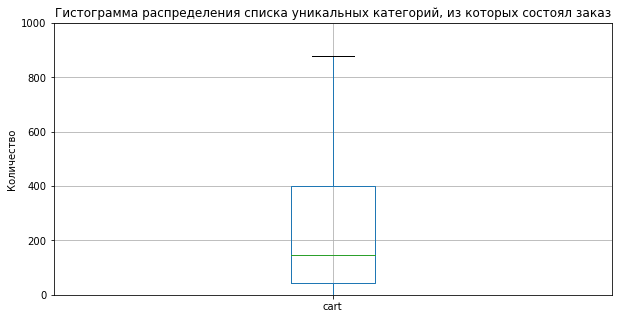

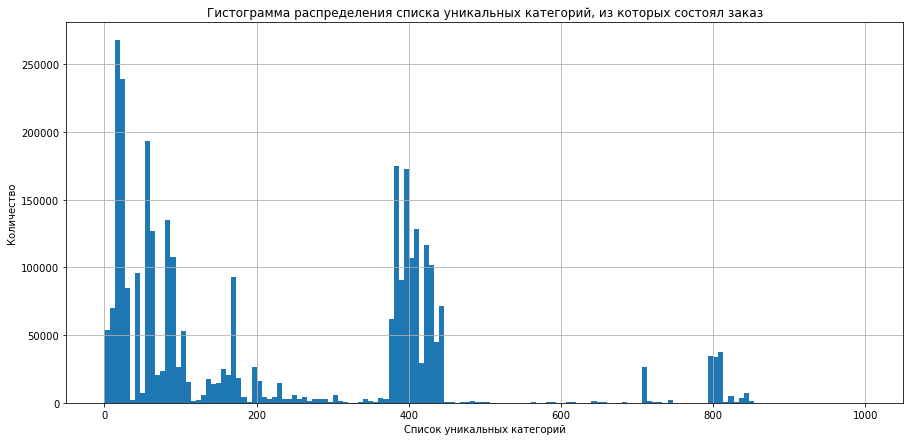

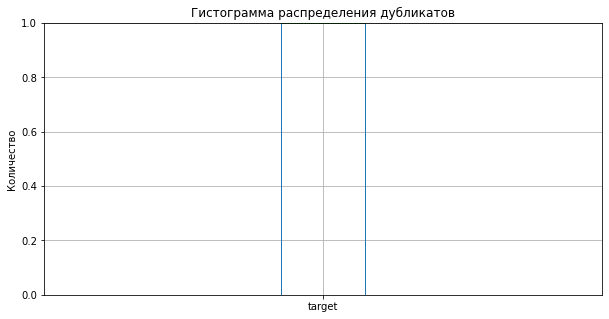

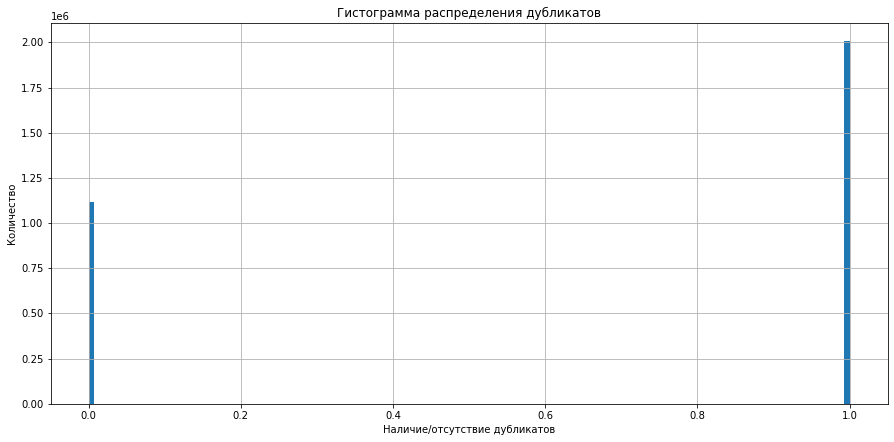

In [11]:
def graf(column_name, range, title, title2):
    data_train.boxplot(column = column_name, figsize = (10, 5))
    plt.ylim(range)
    plt.title(title);
    plt.ylabel('Количество');

    data_train.hist(column_name, bins = 150, range = range, figsize = (15, 7)) 
    plt.title(title);
    plt.xlabel(title2);
    plt.ylabel('Количество');

    plt.show()
    
graf('cart', (0, 1000), 'Гистограмма распределения списка уникальных категорий, из которых состоял заказ', 'Список уникальных категорий')
graf('target', (0,1), 'Гистограмма распределения дубликатов', 'Наличие/отсутствие дубликатов')    

In [12]:
data_train

,user_id,cart,target
0,2,399,0
1,2,14,0
2,2,198,0
3,2,88,0
4,2,157,0
...,...,...,...
3123059,12702,441,1
3123060,12702,92,0
3123061,12702,431,1
3123062,12702,24,1


In [13]:
data_count = data_train.groupby('user_id', as_index = False).count()
del data_count['target']
data_count

,user_id,cart
0,0,44
1,1,37
2,2,172
3,3,62
4,4,112
...,...,...
19995,19995,9
19996,19996,17
19997,19997,42
19998,19998,19


In [14]:
data_count['cart'].mean()

156.1532

In [15]:
data_count['cart'].median()

88.0

In [16]:
data_count['cart'].max()

3508

In [17]:
data_count['cart'].min()

3

In [18]:
data_count_100 = data_count[data_count['cart'] < 100].count()
data_count_100

user_id    10990
cart       10990
dtype: int64

In [19]:
data_count_50 = data_count[data_count['cart'] < 50].count()
data_count_50

user_id    5227
cart       5227
dtype: int64

In [20]:
data_count_10 = data_count[data_count['cart'] < 10].count()
data_count_10

user_id    228
cart       228
dtype: int64

#### Выводы:
- Можно заметить, что есть несколько популярных категорий, которые встречаются довольно часто, а есть категории, по которым покупок почти не совершается. Это не может не сказаться на нашей модели.
- Разбивка по пользователям показывает, что часть из них покупает довольно часто, а часть почти не совершает покупок. Только половина из них совершила более 100 покупок; нужно уточнить у бизнеса, какое количество покупок считается у них достаточным и оценить показатели по нашей выборке.
- 2/3 продуктов покупали хотя бы 2 раза.

### Построим матрицу корреляций и отобразим её.

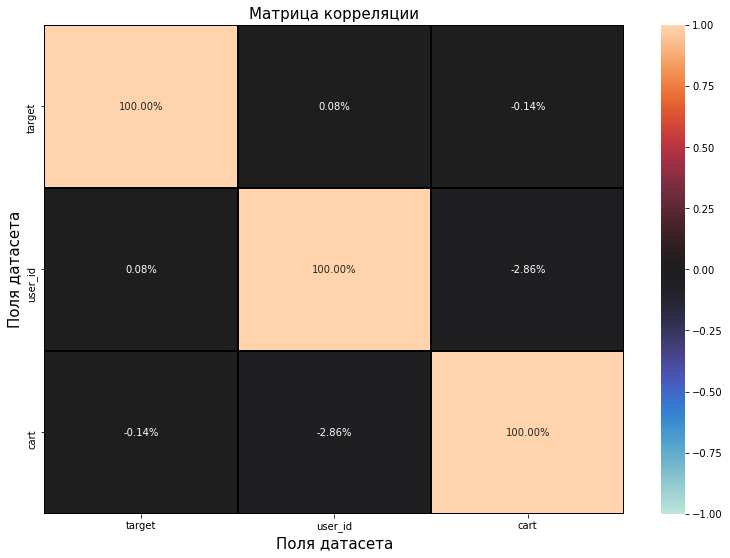

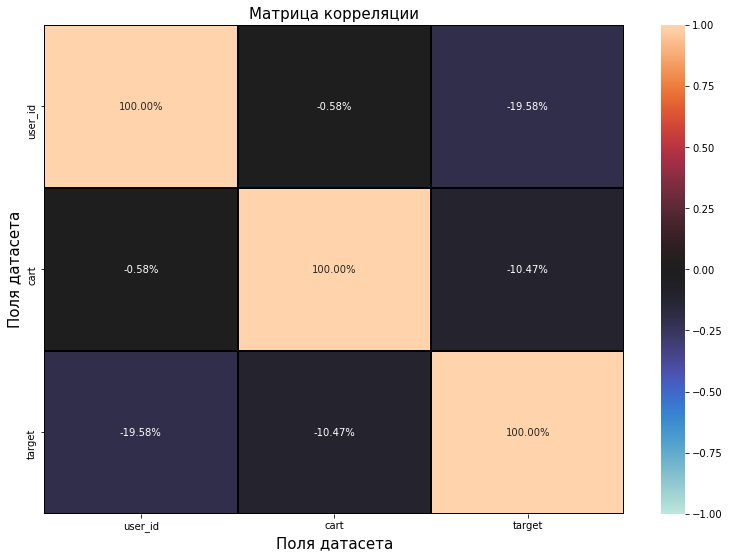

In [21]:
# Создадим тепловую карту
def heatmap(data):
    cm = data.corr()  
    plt.figure(figsize=(13, 9))
    plt.title('Матрица корреляции', fontsize = 15)
    sns.heatmap(cm, annot=True, fmt='.2%', linewidths=1, linecolor='black', 
             xticklabels= cm.columns, yticklabels= cm.index,
             vmin=-1, vmax=1, center= 0)
    plt.xlabel('Поля датасета', fontsize = 15);
    plt.ylabel('Поля датасета', fontsize = 15);
    plt.show()
    
heatmap(data_sample)
heatmap(data_train)

#### Выводы:
В данных нет пар мультиколлинеарных признаков.

## Шаг 3. Построим модель прогнозирования

In [22]:
# разделяем модель на обучающую и валидационную выборку

X_train = data_train.drop('target', axis=1)
y_train = data_train['target']

X_test = data_sample[['user_id', 'cart']]
y_test = data_sample['target']


# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# задаём список моделей
models = [
    LogisticRegression(random_state = 0),
    RandomForestClassifier(random_state = 0),
]

# функция, которая принимает на вход модель и данные, выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)
    print(
        'accuracy_score:{:.5f} precision_score:{:.5f} recall_score:{:.5f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )


# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )

# Добавляем предсказанные величины в таблицу    
model = LogisticRegression(random_state = 0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
X_test['target'] = y_pred

LogisticRegression(random_state=0)
[1 1 1 ... 0 0 0]
accuracy_score:0.50038 precision_score:0.50074 recall_score:0.79768 
RandomForestClassifier(random_state=0)
[0 0 0 ... 0 0 0]
accuracy_score:0.50075 precision_score:0.50191 recall_score:0.40577 


### Вывод:
- Значительная разница в метрике recall важнее, чем небольшое преимущество метрик accuracy и precision, так что остановимся на методе LogisticRegression.

## Шаг 4. Сформируем csv файл с результатом

In [23]:
# Создадим столбец id в том виде, чтобы результат смог провериться на платформе
X_test['id'] = X_test.user_id.apply(str) + ';' + X_test.cart.apply(str)

In [24]:
submission = pd.DataFrame({'id': X_test['id'], 'target': X_test['target']})
submission.to_csv('submission.csv', index=False)

## Общие выводы:
- Данные достаточно репрезентативны;
- Категориальных переменных нет;
- Пропусков и дубликатов нет;
- В данных нет пар мультиколлинеарных признаков;

- Можно заметить, что есть несколько популярных категорий, которые встречаются довольно часто, а есть категории, по которым покупок почти не совершается. Это не может не сказаться на нашей модели.
- Разбивка по пользователям показывает, что часть из них покупает довольно часто, а часть почти не совершает покупок. Только половина из них совершила более 100 покупок; нужно уточнить у бизнеса, какое количество покупок считается у них достаточным и оценить показатели по нашей выборке.
- 2/3 продуктов покупали хотя бы 2 раза.

- Метрики лучше у метода LogisticRegression.

